# Mask R-CNN Training and Inference
이 노트북에서는 Matterport의 Mask R-CNN 구현을 사용하여 사용자 지정 데이터 세트를 학습 한 다음 학습 된 가중치를 사용하여 새 이미지에 대한 추론을 실행합니다.

이것은 http://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset에 게시 된 자습서의 일부이므로 자세한 내용은 거기에서 확인하십시오.

초보자 튜토리얼이 아닙니다 ...
이것은 완전한 초보자 튜토리얼이 아닙니다.

GitHub에서 git 저장소를 복제하는 방법을 알아야합니다.
Python 프로그래밍에 대한 적절한 이해가 있어야합니다.
심층 신경망 훈련의 기본 사항을 이해해야합니다. 전에 해본 적이 없다면 여기서 시작하지 않는 것이 좋습니다. 초보자 딥 러닝 튜토리얼 / 강좌를 찾아서 시작하십시오. YouTube에는 멋진 무료 콘텐츠가 많이 있습니다.
** 먼저 무료 교육 데이터 세트를 다운로드하십시오!
이 튜토리얼에서 사용할 수 있도록 담배 꽁초 이미지의 무료 교육 데이터 셋을 제공했습니다. 1. 여기에서 다운로드하십시오 : http://www.immersivelimit.com/datasets/cigarette-butts 2. 그런 다음 파일을 추출하여이 저장소의 "../datasets"디렉토리에 넣으십시오. 3. 아래 코드는 다음과 같습니다. "../datasets/cig_butts/train", "../datasets/cig_butts/val"및 "../datasets/cig_butts/real_test"검색

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

## Import Matterport's "mrcnn" libraries
1. I'm using a forked version of Matterport's Mask_RCNN git repo to make sure this code works, even if the main repo changes. As of July 29, 2018, there is a bug in Matterport's version that breaks loading an existing model that I've fixed in my version (and submitted a pull request to fix it in theirs).
  - My version is here: https://github.com/akTwelve/Mask_RCNN
  - The original is here: https://github.com/matterport/Mask_RCNN
2. Update the code cell below to point to the root directory of the repo on your machine.

메인 리포지토리가 변경된 경우에도이 코드가 작동하는지 확인하기 위해 Matterport의 Mask_RCNN git 리포지토리의 분기 버전을 사용하고 있습니다. 2018 년 7 월 29 일 현재, Matterport 버전에는 내가 내 버전에서 수정 한 기존 모델로드를 중단하는 버그가 있습니다 (그리고 수정 요청을 제출했습니다).
내 버전은 여기 : https://github.com/akTwelve/Mask_RCNN
원본 : https://github.com/matterport/Mask_RCNN
시스템에있는 저장소의 루트 디렉토리를 가리 키도록 아래 코드 셀을 업데이트하십시오.

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../../aktwelve_Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

로깅 및 사전 학습 된 모델 경로 설정
이것은 mask_rcnn_dir의 하위 디렉토리로 기본 설정되지만 다른 곳에서 원하는 경우 여기에서 업데이트하십시오.

사전 훈련 된 coco 모델도 다운로드합니다.

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configuration
Define configurations for training on the Cigarette Butt dataset.
### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

## 구성
Cigarette Butt 데이터 세트에 대한 교육용 구성을 정의합니다.
### 노트
내 컴퓨터 (GTX 970 그래픽 카드)에서 작동하는 설정입니다. OOM (메모리 부족) 오류가 발생하는 경우 설정을 조정해야하거나 컴퓨터가 충분히 강력하지 않을 수 있습니다. 더 나은 그래픽 카드를 가지고 있다면 그것을 활용하기 위해 그것을 조정하고 싶을 것입니다.

In [5]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    담배 꽁초 데이터 세트에 대한 학습을위한 구성입니다.
    기본 Config 클래스에서 파생되며 특정 값을 재정의합니다.
    담배 꽁초 데이터 셋에
    """
    # Give the configuration a recognizable name
    #구성에 인식 가능한 이름을 지정하십시오.
    NAME = "cig_butts"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    # GPU 1 개와 GPU 당 이미지 1 개로 학습합니다. 배치 크기는 1 (GPU * 이미지 / GPU)입니다.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background) #
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    #이 숫자로 실험하여 훈련이 향상되는지 확인할 수 있습니다.
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # 유효성 검사가 실행되는 빈도입니다. 너무 많은 하드 드라이브 공간을 사용하는 경우
    # on saved models (in the MODEL_DIR), try making this value larger.
    # 저장된 모델 (MODEL_DIR)에서이 값을 더 크게 만드십시오.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    # Matterport는 원래 resnet101을 사용했지만 그래픽 카드에 맞게 크기를 줄였습니다.
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    # 솔직히 말해서 이것들이 무엇을하는지 알아내는 데 시간이 걸리지 않았습니다.
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

나는 이것을 COCO와 같은 데이터 세트에 일반화하려고 시도했습니다. 즉, COCO 형식으로 정의 된 다른 데이터 세트가있는 경우 작동합니다.

In [6]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        # utils.Dataset의 기본 메서드를 사용하여 클래스 이름을 추가합니다.
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.


        주어진 이미지에 대한 인스턴스 마스크를로드합니다.
        MaskRCNN은 비트 맵 [높이, 너비, 인스턴스] 형식의 마스크를 예상합니다.
        인수 :
            image_id : 마스크를로드 할 이미지의 ID
        보고:
            마스크 : [높이, 너비, 인스턴스 수] 모양의 부울 배열
                인스턴스 당 하나의 마스크.
            class_ids : 인스턴스 마스크의 클래스 ID의 1D 배열.
            
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

이 노트북 상단에 링크 된 교육 데이터 세트를 다운로드해야합니다. 데이터 세트를 다른 곳에 배치하는 경우 아래 경로를 업데이트하세요.

In [8]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../datasets/cig_butts/train/coco_annotations.json', '../datasets/cig_butts/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../datasets/cig_butts/val/coco_annotations.json', '../datasets/cig_butts/val/images')
dataset_val.prepare()

## Display a few images from the training dataset

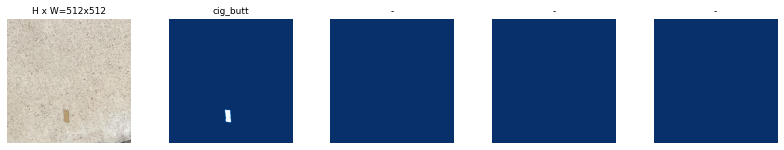

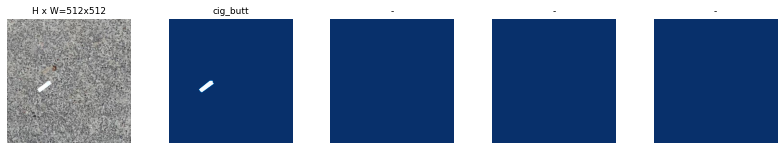

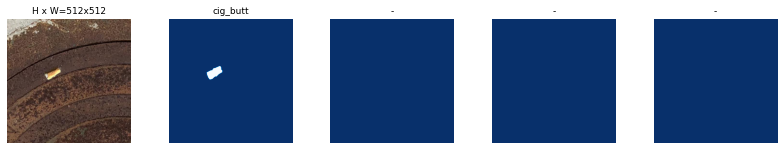

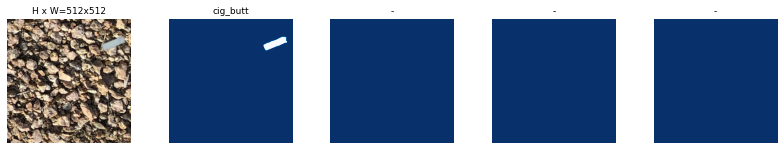

In [9]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

두 단계로 훈련 :

1. 머리 만. 여기서 우리는 모든 백본 레이어를 고정하고 무작위로 초기화 된 레이어 (예 : MS COCO의 사전 훈련 된 가중치를 사용하지 않은 레이어) 만 훈련합니다. 헤드 레이어 만 훈련하려면 layer = 'heads'를 train () 함수에 전달하십시오.

2. 모든 레이어를 미세 조정합니다. 이 간단한 예에서는 필요하지 않지만 프로세스를 보여주기 위해 포함합니다. 모든 레이어를 학습하려면 layers = "all을 전달하기 만하면됩니다.



In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

# 머리 가지 훈련
# Layer = "heads"를 전달하면 헤드를 제외한 모든 레이어가 고정됩니다.
# 레이어. 정규식을 전달하여 선택할 수도 있습니다.
# 이름 패턴으로 훈련 할 레이어.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')
'''
85s 170ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.5854 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.0930 - val_loss: 0.4142 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.2444 - val_mrcnn_class_loss: 0.0330 - val_mrcnn_bbox_loss: 0.0665 - val_mrcnn_mask_loss: 0.0674
Training took 6.51 minutes
'''

pe. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
467/500 [===========================>..] - ETA: 5s - batch: 233.0000 - size: 1.0000 - loss: 0.5892 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.3747 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.0931C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. St

In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# 모든 레이어를 미세 조정
# 통과층="모두"는 모든 층을 훈련시킨다. 당신은 또한
# 정규식을 전달하여 원하는 레이어를 선택합니다.
# 이름 패턴으로 훈련합니다.

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')
'''
batch: 249.5000 - size: 1.0000 - loss: 0.3903 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0773 - val_loss: 0.4759 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.0873 - val_mrcnn_class_loss: 0.0132 - val_mrcnn_bbox_loss: 0.0450 - val_mrcnn_mask_loss: 0.0903
Training took 13.8 minutes
'''

es\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
472/500 [===========================>..] - ETA: 9s - batch: 235.5000 - size: 1.0000 - loss: 0.3949 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0781 C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
473/500 [===========================>..] - ET

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

새 추론 구성을 만든 다음 이를 사용하여 새 모델을 만듭니다.

In [15]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [16]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [17]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../aktwelve_Mask_RCNN\logs\cig_butts20210527T1956\mask_rcnn_cig_butts_0008.h5
Re-starting from epoch 8


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

모델을 실행합니다.실물을 탐지하다

잘못된 긍정도 있고, 빗나간 것도 있습니다. 결과를 개선하기 위해 더 많은 훈련 이미지가 필요할 것 같다.

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


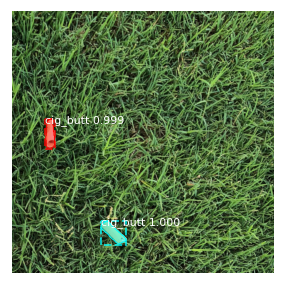

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


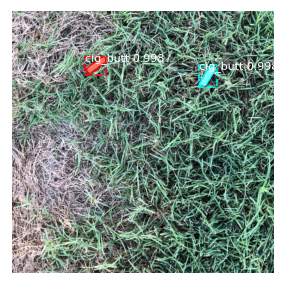

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


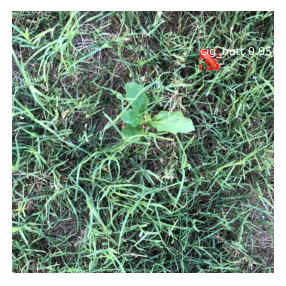

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


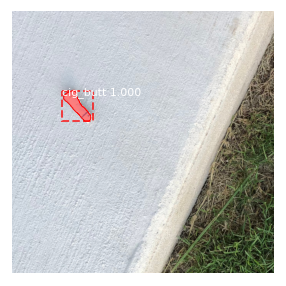

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


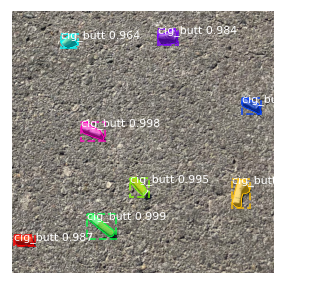

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


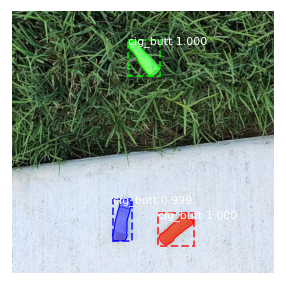

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


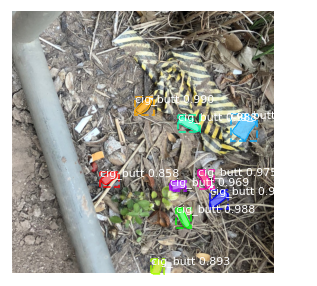

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


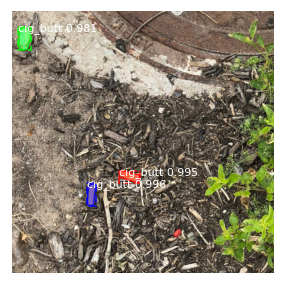

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


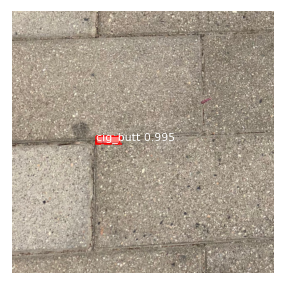

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


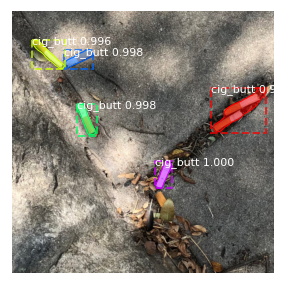

In [19]:
import skimage
real_test_dir = '../datasets/cig_butts/real_test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))